# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# --------------------------
# Load general numerical packages
# --------------------------
import numpy as np
import pandas as pd
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Load sklearn
# --------------------------
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc 
import sklearn.metrics as metrics

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

# --------------------------
# Plotting
# --------------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

# --------------------------
# Other packages
# --------------------------
import statsmodels.api as sm
from statsmodels.api import OLS
from IPython.display import display

In [3]:
# increase display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Preparing the data
* **Part 2**: Resample to achieve balanced classes
* **Part 3**: Scale the data and generate train/test splits
* **Part 4** Determine significant predictors
* **Part 5**: Exploring the data

<div class='exercise'><b> Part 1: Preparing the data </b></div>

This notebook uses the cleaned CSV data file `data_cleaned_2016_2017.csv` downloaded from https://drive.google.com/open?id=1LCk-dDFC7O_6ek1i0IIGqE07Rq-kf1Xz. <br><br>
The cleaned dataset still needs some pre-processing in order to make it ready for modelling. This includes:

* Removing several more columns that are not informative, for example where they duplicate other information or only have a single value
* Drop the last digits of the zip code
* Recoding some ordinal variables into numerical scales
* Recoding some categorical variables into dummy variables

In [4]:
# read in the 2016-2017 data set
original_df = pd.read_csv('../../../data/data_cleaned_2016_2017.csv', low_memory = False)

In [5]:
# --------------------------
# Function to finalise data preparation
# --------------------------
def data_prep(df):
    '''Returns a cleaned up dataframe as basis for the EDA analysis
    Input:
        df: the pd.DataFrame object
    Returns:
        clean_df: pd.DataFrame object
    '''
    clean_df = df.copy()
    
    # --------------------------
    # Definitions
    # --------------------------
    cols_to_remove = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                      'mo_sin_rcnt_tl', 'funded_amnt', 'funded_amnt_inv', 'num_sats', 
                   'application_type', 'num_actv_rev_tl', 'pymnt_plan']
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
    prefixes = ['home', 'verify', 'purp', 'state']
    
    # --------------------------
    # Drop additional uninformative columns
    # --------------------------
    clean_df = clean_df.drop(columns=cols_to_remove)
    
    # --------------------------
    # Strip xx from zip code
    # --------------------------
    clean_df["zip_code"] = [x.strip("xx") for x in clean_df["zip_code"].astype(str)]
    clean_df["zip_code"] = clean_df["zip_code"].astype(int)
    
    # --------------------------
    # Exclude zip code from set of predictors for analysis
    # --------------------------
    # to be added back in later for checking discrimination...
    clean_df = clean_df.drop(columns='zip_code')

    # --------------------------
    # Ordinal columns are encoded as numerical values
    # --------------------------
    clean_df["grade"].replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}, inplace = True)
    clean_df["sub_grade"].replace({"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
                                "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
                                "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
                                "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
                                "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
                                "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
                                "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}, inplace = True)

    # --------------------------
    # Nominal columns are encoded via hot encoding by adding more columns
    # --------------------------
    clean_df = pd.get_dummies(clean_df, columns=nominal_columns, prefix=prefixes, drop_first=True)

    return clean_df

In [6]:
df_all = data_prep(original_df)

In [7]:
df_all.shape

(334109, 140)

<div class='exercise'><b> Part 2: Resample to achieve balanced classes </b></div>

Since we have imbalanced classes that can cause misleading assessment of model performance, we resample the classes here. We also take the opportunity to reduce the dataset size in the initial stages, so that different model specifications can be tested faster.

In [8]:
# Check balance of target values - it is unbalanced
df_all["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,255116
Charged Off,78993


In [9]:
# --------------------------
# Function to downsample and create balanced classes
# --------------------------

def balance_classes(df, n_samples, random_state = 1):
    # --------------------------
    # Define majority and minority classes
    # --------------------------
    df_majority = df[df["loan_status"] == "Fully Paid"]
    df_minority = df[df["loan_status"] == "Charged Off"]
    
    # --------------------------
    # Downsample majority and minority classes
    # --------------------------
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,   
                                     random_state = random_state) # set random seed for reproducability

    df_minority_downsampled = resample(df_minority, 
                                     replace = False,
                                     n_samples = n_samples,   
                                     random_state = random_state) 

    # --------------------------
    # Recombine
    # --------------------------
    df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

    return df_downsampled

In [10]:
# Define how many samples of each we want
n_samples = 10000

df = balance_classes(df_all, n_samples)

In [11]:
df["loan_status"].value_counts().to_frame()

,loan_status
Charged Off,10000
Fully Paid,10000


<div class='exercise'><b> Part 3: Scale the data and generate train/test splits </b></div>

Since we will be using models that are sensitive to scale, we need to scale the data. This is done in a function for reproducability.

<font color = "red">
NB: added stratify argument to train test split to ensure we still have 50:50 balance

In [12]:
# Function to generate train test splits and scale the data
def get_train_test(df, test_size = 0.2, random_state = 1):
    nonbinary_columns = ['loan_amnt','int_rate','installment','grade','sub_grade','emp_length',
                         'annual_inc','issue_d','dti', 'delinq_2yrs','earliest_cr_line','inq_last_6mths', 
                         'open_acc','pub_rec','revol_bal','revol_util','total_acc', 'annual_inc_joint',
                         'dti_joint','acc_now_delinq','open_acc_6m','open_act_il', 'open_il_12m',
                         'open_il_24m', 'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                         'all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths',
                         'avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
                         'delinq_amnt','mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl',
                         'num_bc_sats','num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                         'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
                         'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                         'tax_liens', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_revol_util',
                         'sec_app_mths_since_last_major_derog']
    result = df.copy()
    
    # --------------------------
    # Train test split
    # --------------------------
    
    data_train, data_test = train_test_split(result, 
                                             test_size = test_size, 
                                             random_state = random_state,
                                            stratify = result.loan_status)
    X_train = data_train.iloc[:, data_train.columns != 'loan_status']
    y_train = data_train['loan_status']
    X_test = data_test.iloc[:, data_test.columns != 'loan_status']
    y_test = data_test['loan_status']
    
    # --------------------------
    # Scaling: Incorporate here so that we can use it consistently across all models
    # --------------------------

    scaler = StandardScaler()
    X_train[nonbinary_columns] = scaler.fit_transform(X_train[nonbinary_columns])
    X_test[nonbinary_columns] = scaler.transform(X_test[nonbinary_columns])
    
    # --------------------------
    # Recode loan status
    # --------------------------
  
    y_train = y_train.replace({'Fully Paid': 1, 'Charged Off': 0})
    y_test = y_test.replace({'Fully Paid': 1, 'Charged Off': 0})
    
    return X_train, y_train, X_test, y_test

In [13]:
# Create scaled train and test sets
X_train, y_train, X_test, y_test = get_train_test(df)


In [14]:
y_train.value_counts().to_frame()

,loan_status
1,8000
0,8000


<div class='exercise'><b> Part 4: Mapping </b></div>

Playing with some maps to display the data

In [15]:
# Install plotly if needed
#!pip install plotly 

In [16]:
# Import map visulization libraries
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

In [17]:
# Recode loan status
original_df["loan_status"] = original_df["loan_status"].replace({'Fully Paid': 1, 'Charged Off': 0})


In [18]:
# Aggregating data by State
default_rate = 1 - original_df.groupby(["addr_state"]).mean()["loan_status"]

In [19]:
# --------------------------
# Set up inputs for the map
# --------------------------
data = [ dict(
        type = 'choropleth',
        locations = default_rate.index,
        z = default_rate, 
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Default rate")
        ) ]

layout = dict(
        title = 'Lending Club Average Default Rate By State',
        geo = dict(
            scope = 'usa',
            projection = dict(type = 'albers usa' ),
            showlakes = True, 
            lakecolor = 'rgb(255, 255, 255)'),)
    

In [20]:
# --------------------------
# Create map
# --------------------------
fig = dict(data = data, 
           layout = layout)
iplot(fig, filename = 'd3-cloropleth-map')

<div class='exercise'><b> Part 5: Model performance metrics </b></div>

In this section, we develop a wrapper function that will allow for multiple models to be trained and tested according to different performance metrics

Since the cost of a false positive is relatively high, this needs to be accounted for when choosing the best model. For the purposes of this project, we consider several metrics:

* __Precision__ = True positive / (True positive + False positive)
* __Recall__ = True positive / (True positive + False negative)
* __F1 score__ = harmonic mean of precision and recall

There is typically a trade-off between precision and recall.

Precision represents how precise the model is in predicting positive values, and is a good metric to use when the cost of false positives is high, as in our case. 

Recall represents how many of the actual positives were correctly picked up by the model. It is important to use when the cost of false negatives is high. 

Although we are not so concerned about false negatives in our model, we still want a good overall performance. Another metric to consider is therefore the F1, which is 2 x (Precision x Recall)/(Precision + Recall) and therefore seeks to create a balance between these two metrics. 

Resources used:
* Graph showing optmisation according to scoring: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
* Inspiration for use of different metrics: https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

<font color = "red">
The code below is basically reworking those two websites above.
I realised after playing with the models a bit that we probably need to use a mixture of metrics to get the best overall model, otherwise if we just use precision we trade off too much on recall.


In [21]:
# --------------------------
# Define scores to use
# --------------------------
scoring = {
    'AUC': 'roc_auc', # Area under the curve
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. 

Setting refit_score = 'AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score. Other metrics could also be used. 

In [22]:
# --------------------------
# Function that use GridSearchCV to find the model with the best parameters 
# According to the specified "refit score"
# --------------------------
def grid_search_wrapper(clf, param_grid, refit_score='AUC'):  
    '''
    Finds the optimal model according to "refit score" using GridSearchCV
    Prints model performance metrics
    Input:
        clf: the classification model
        param_grid: grid of parameters to search over
        refit_score: AUC or precision_score
    Returns:
        grid_search: fitted model object
    '''
    # --------------------------
    # Fit the classifier model
    # --------------------------
    grid_search = GridSearchCV(clf, 
                               param_grid, 
                               scoring = scoring, 
                               refit = refit_score,
                               cv = 5, 
                               return_train_score = True, 
                               n_jobs = -1, # Parallel processing
                              error_score = 0) # Ensures model completes even if parameters cause one or more folds to fail
    grid_search.fit(X_train.values, y_train.values)
    

    # --------------------------
    # Review parameters and performance for best model
    # --------------------------
    y_test_pred = grid_search.predict(X_test.values)
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # --------------------------
    # Print confusion matrix (test data)
    # --------------------------
    print('\nConfusion matrix of model optimized for {} on the test data:'.format(refit_score))
    display(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    # --------------------------
    # Print classification report
    # --------------------------
    print("\nClassification report for best model:")
    print(classification_report(y_test, y_test_pred, digits = 2))
    
    return grid_search

In [23]:
# --------------------------
# Define model and parameter grid - start with L2 logistic regression
# --------------------------
model = LogisticRegression(penalty = 'l2')
param_grid = {"C": np.logspace(-5, 0.5, 10)}


In [24]:
# Fit the logistic regression
logistic_L2 = grid_search_wrapper(model, param_grid, 
                                  refit_score = 'AUC')

Best params for AUC
{'C': 0.04641588833612782}

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,1351,649
pos,699,1301



Classification report for best model:
             precision    recall  f1-score   support

          0       0.66      0.68      0.67      2000
          1       0.67      0.65      0.66      2000

avg / total       0.66      0.66      0.66      4000



In [25]:
# Try with a random forest (takes ages to run)
model = RandomForestClassifier()

param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators' : [300, 500]
}

# Use grid search wrapper
random_forest = grid_search_wrapper(model, param_grid, 
                                  refit_score = 'AUC')

Best params for AUC
{'max_depth': 15, 'n_estimators': 500}

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,1396,604
pos,785,1215



Classification report for best model:
             precision    recall  f1-score   support

          0       0.64      0.70      0.67      2000
          1       0.67      0.61      0.64      2000

avg / total       0.65      0.65      0.65      4000



In [53]:
# --------------------------
# Function to generate the plots
# --------------------------

def plot_scorers(model, param_to_plot):
    grid_search = model
    results = model.cv_results_ # Get the CV results to show error bars
    best_model = grid_search.best_estimator_
    
    # --------------------------
    # Retrieve predicted probabilities for the best model &
    # Get performance for different thresholds
    # --------------------------
    y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
    F1 = 2*(p[:-1]*r[:-1])/(p[:-1]+r[:-1])
    
    # --------------------------
    # Plots the first two scorers - AUC and precision
    # --------------------------

    gridsize = (3, 2)
    fig = plt.figure(figsize=(14, 16))
    ax0 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1 = plt.subplot2grid(gridsize, (2, 0))
    ax2 = plt.subplot2grid(gridsize, (2, 1))

    ax0.set_title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize = 16)

    ax0.set_ylim(0.6, 0.9) # Zoom in so that differences can be seen
    ax0.set_xlabel(str(param_to_plot))
    ax0.set_ylabel("Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+str(param_to_plot)].data, dtype=float)

    # Plot the first two scorers
    for scorer, color in zip(scoring, ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax0.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax0.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax0.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax0.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    ax0.legend(loc="best");

    # --------------------------
    # Make graphs to show ROC and Precision-recall curves
    # --------------------------

    # ROC plot
    ax1.set_title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_prob))
    ax1.plot(fpr, tpr, 'b')
    ax1.plot([0,1], [0,1], 'r--')
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate');

    # Precision-recall plot
    ax2.set_title("Precision and Recall Scores as a function of the decision threshold")
    ax2.plot(thresholds, p[:-1], "b--", label = "Precision")
    ax2.plot(thresholds, r[:-1], "g-", label = "Recall")
    ax2.plot(thresholds, F1, "k", label = "F1 score")
    ax2.set_ylim([0,1])
    ax2.set_ylabel("Score")
    ax2.set_xlabel("Decision Threshold")
    ax2.legend(loc = "best");

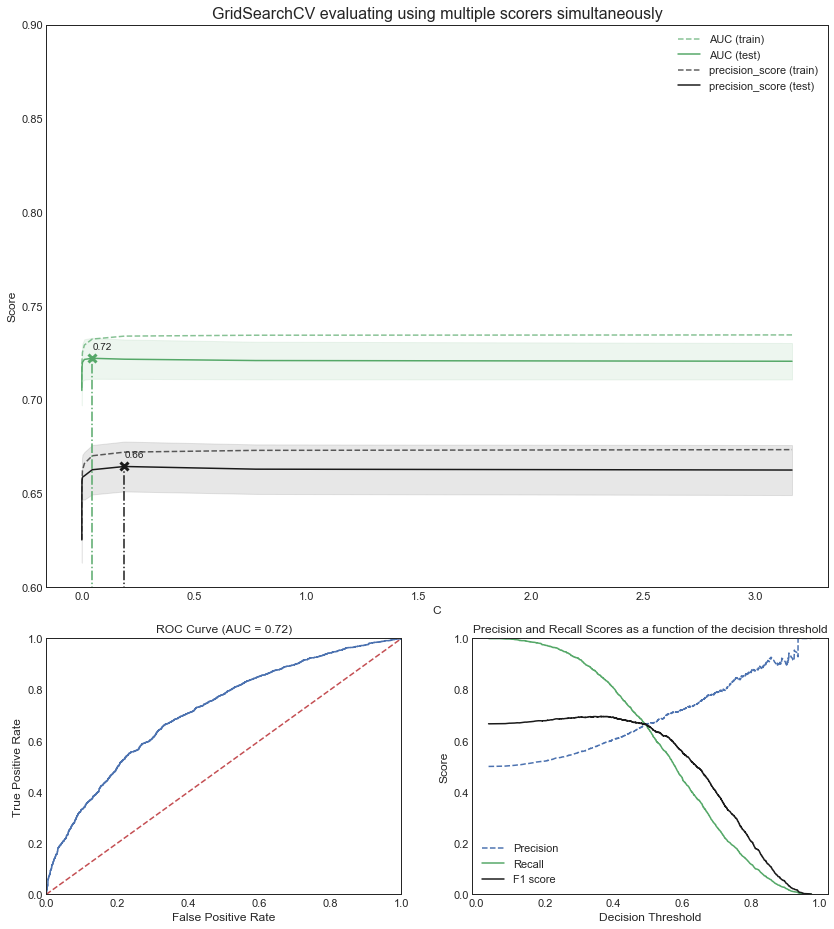

In [54]:
# Try out the plotting on the logistic model

plot_scorers(model = logistic_L2, 
             param_to_plot = "C")

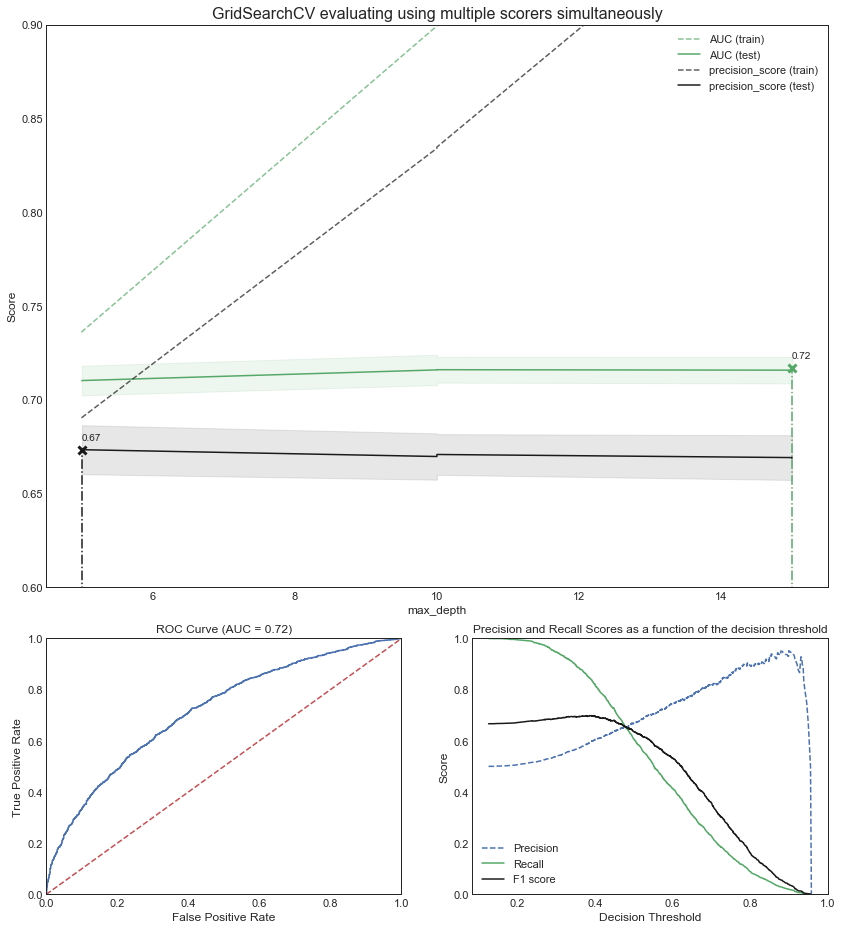

In [55]:
# Try on the random forest

plot_scorers(model = random_forest, 
             param_to_plot = "max_depth")

In [61]:
# --------------------------
# Find the best thresholds to maximise precision and F1 scores
# --------------------------
grid_search = logistic_L2
results = grid_search.cv_results_ # Get the CV results to show error bars
best_model = grid_search.best_estimator_

# --------------------------
# Retrieve predicted probabilities for the best model &
# Get performance for different thresholds
# --------------------------
y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
F1 = 2*(p[:-1]*r[:-1])/(p[:-1]+r[:-1])
    
best_threshold_index = np.argmax(p) 
best_threshold_precision = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]

print("Threshold that maximises precision is:")
print(best_threshold_precision)

best_threshold_index = np.argmax(F1)
best_threshold_F1 = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]
print("Threshold that maximises F1 score is:")
print(best_threshold_F1)

Threshold that maximises precision is:
0.9375632764767943
Threshold that maximises F1 score is:
0.3705505659346028


Notice that the best threshold for precision as found above will always be really high, so it doesn't seem like the best metric to use

In [62]:
# The precision, recall, and accuracy scores for every combination of the parameters in param_grid are stored in cv_results_
# Not fully automatic yet, still need to manually define the headings
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_C']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_C
7,0.664,0.653,0.661,0.189574
8,0.663,0.651,0.660,0.774264
6,0.663,0.654,0.660,0.0464159
9,0.663,0.650,0.659,3.16228
5,0.659,0.655,0.658,0.0113646


In [63]:
## Not used at the moment

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg      1351       649
pos       699      1301


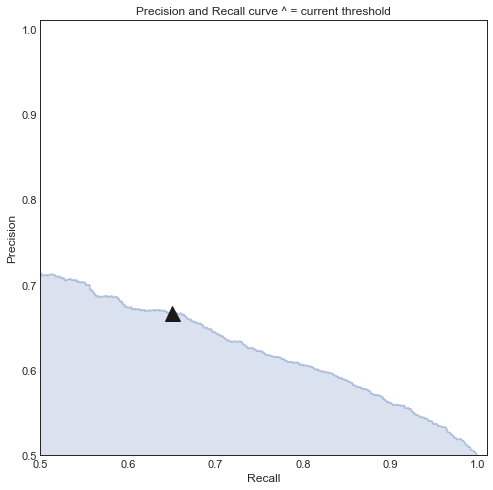

In [64]:
y_scores = grid_search.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

precision_recall_threshold(p, r, thresholds, 0.5)